# Playground

## Design Data Preprocessing 

In [1]:
import configparser

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import wfdb
import scipy.signal

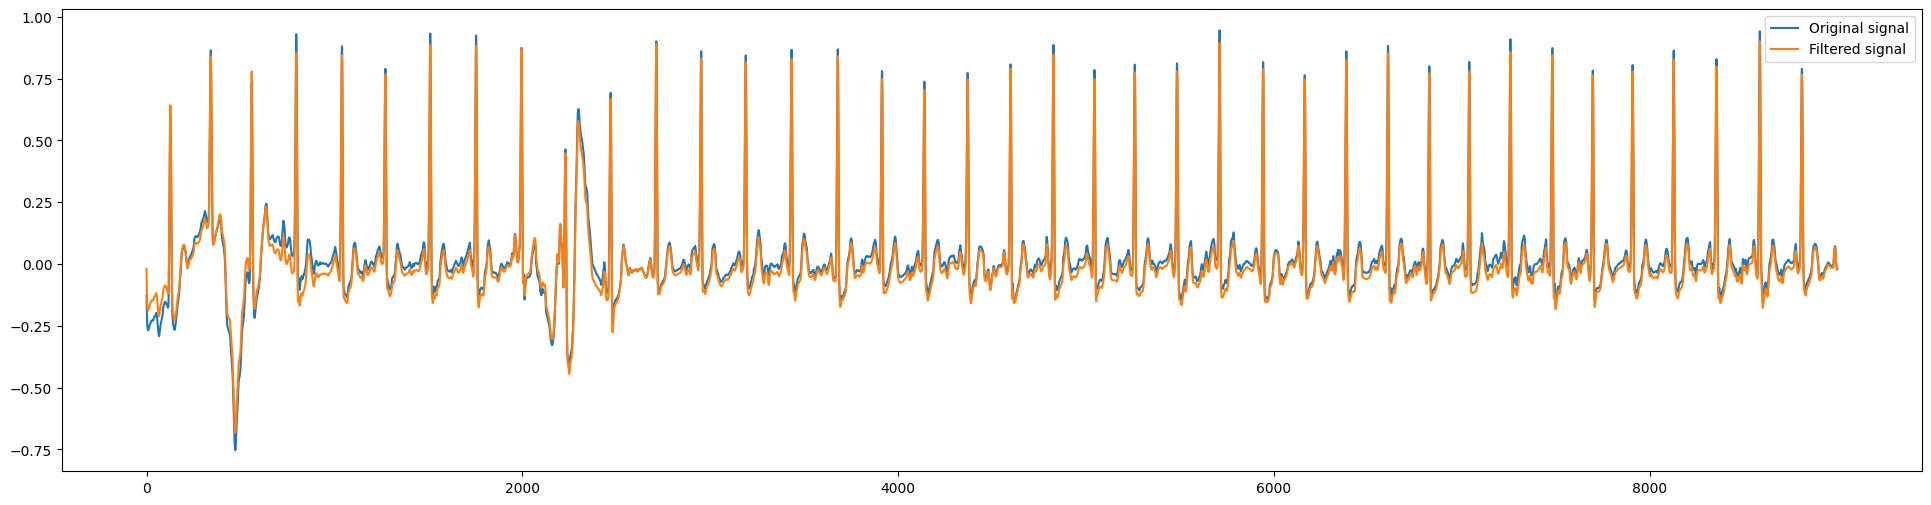

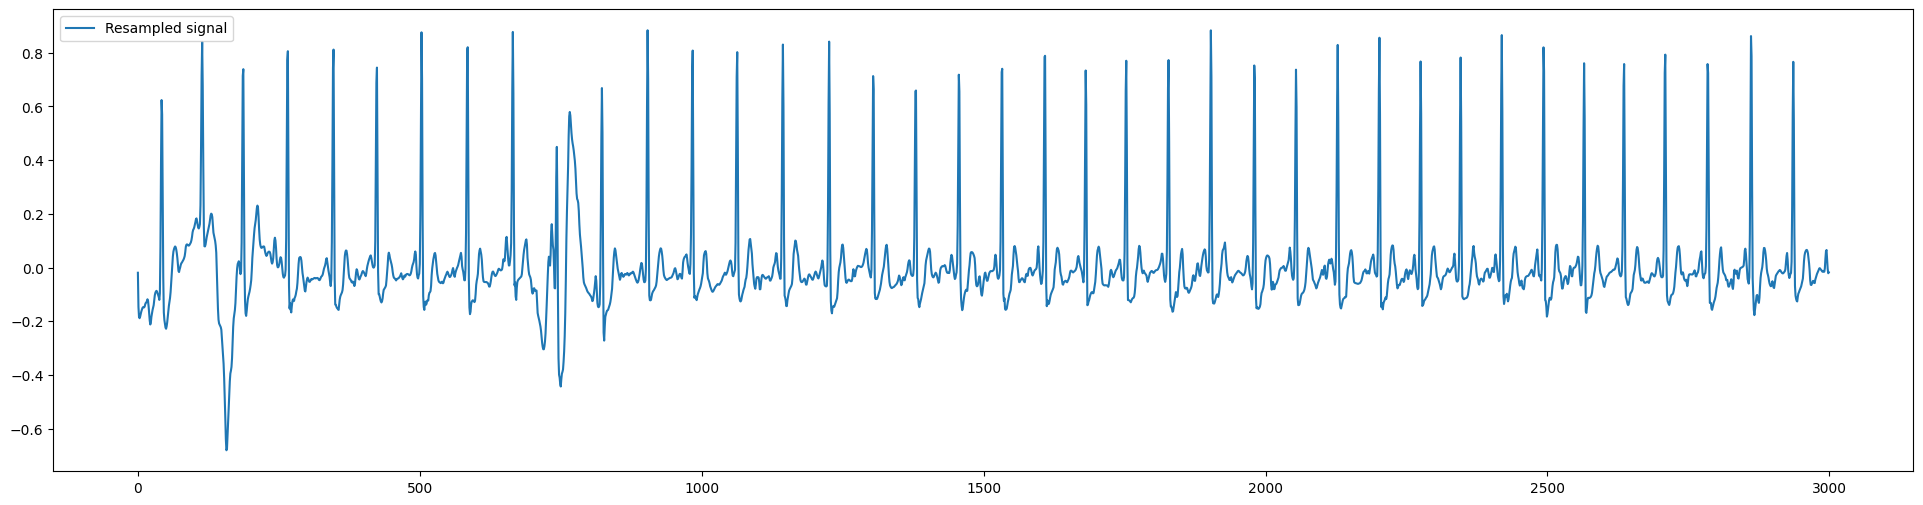

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")
src_freq = config.getint("data_preprocessing", "src_freq")
dst_freq = config.getint("data_preprocessing", "dst_freq")

signal, _ = wfdb.rdsamp("dataset/training2017/A00001")  # min: A04894; max: A06471
signal = np.squeeze(signal)

# pad 1 second to both ends to avoid edge effects during filtering
signal = np.pad(signal, src_freq * 1, "constant", constant_values=0)

## Add baseline wandering
# t = np.linspace(0, len(signal) / src_freq, len(signal))
# baseline_sine = 0.3 * np.sin(2 * np.pi * 0.1 * t) 
# signal += baseline_sine

# denoise
sos = scipy.signal.butter(2, [0.5, 40], btype="bandpass", output="sos", fs=src_freq)
filtered_signal = scipy.signal.sosfiltfilt(sos, signal)

# remove padding
signal = signal[src_freq * 1 : -src_freq * 1]
filtered_signal = filtered_signal[src_freq * 1 : -src_freq * 1]

# downsampling
resampled_signal = nk.signal_resample(
    filtered_signal, sampling_rate=src_freq, desired_sampling_rate=dst_freq
)

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(filtered_signal).plot(figsize=(24, 6), label="Filtered signal")
plt.legend()
plt.show()

pd.Series(resampled_signal).plot(figsize=(24, 6), label="Resampled signal")
plt.legend()
plt.show()

## Check Data Transforms

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset_utils.transforms import *
import torch
import configparser

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


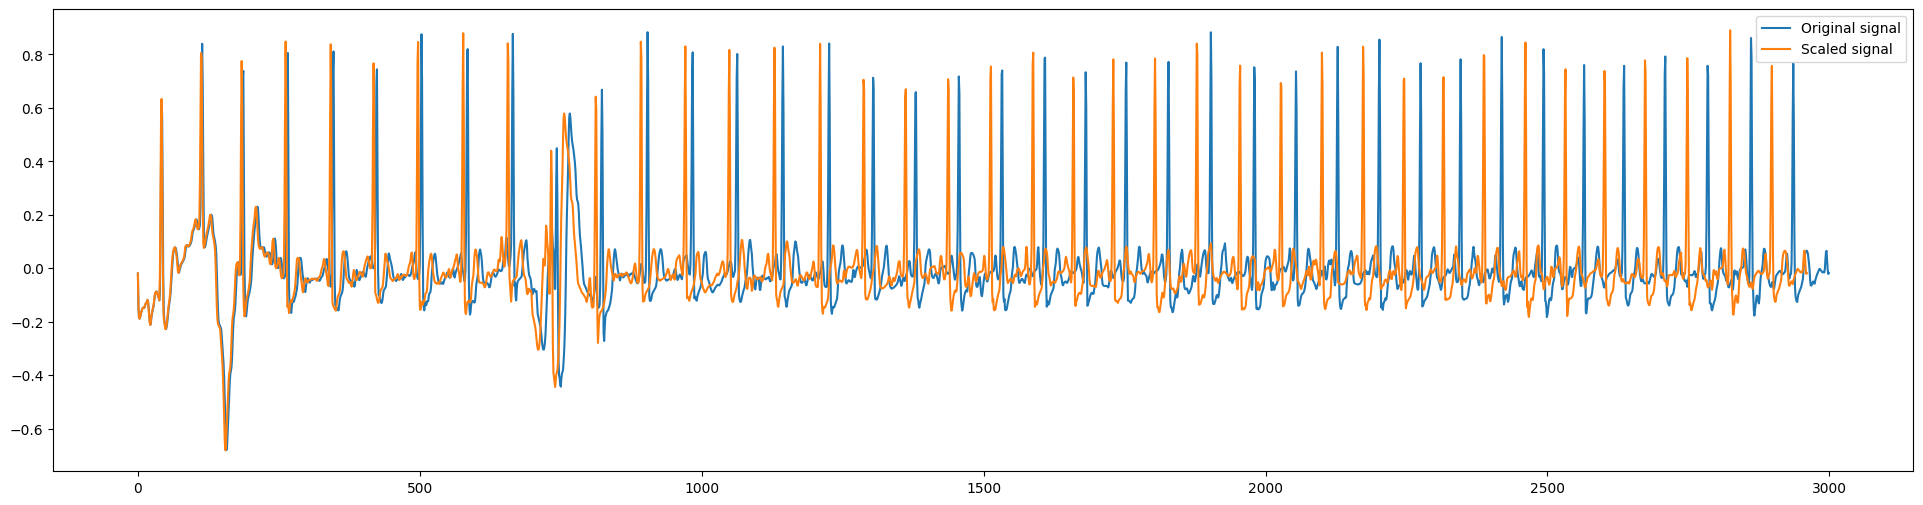

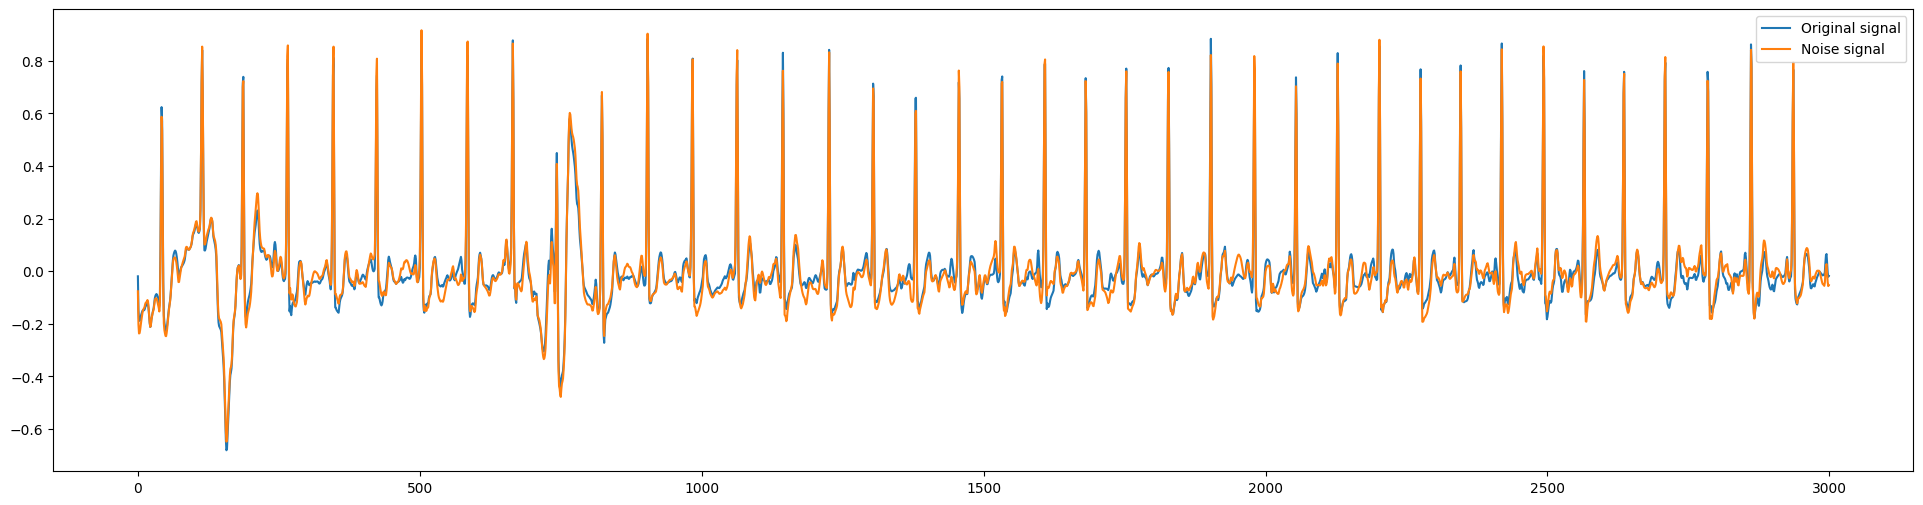

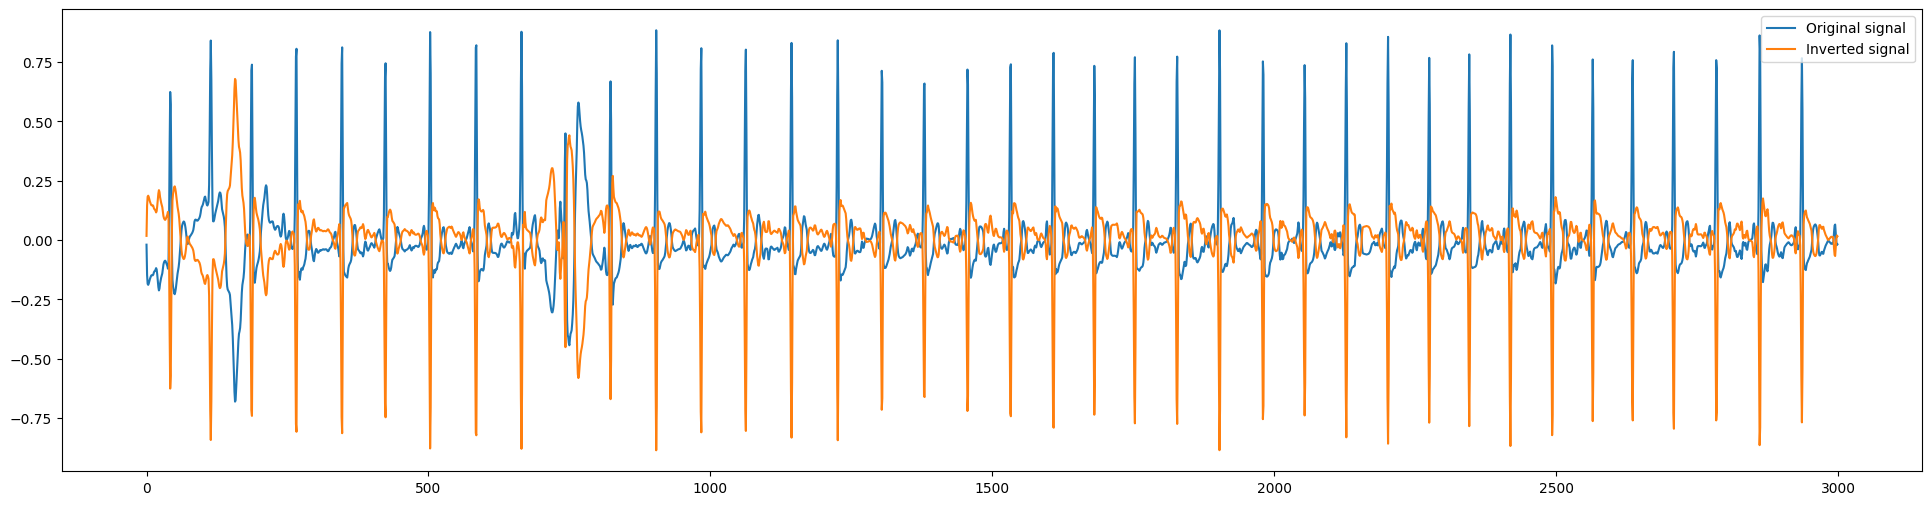

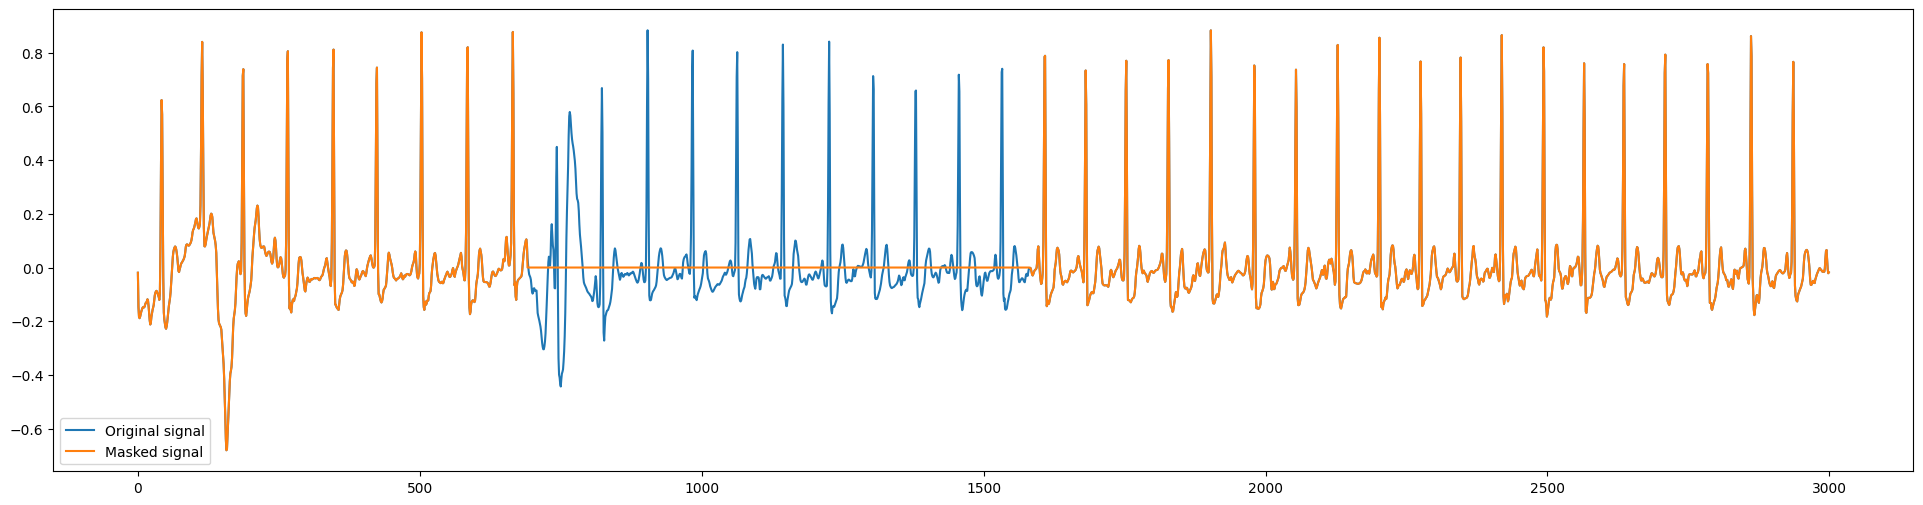

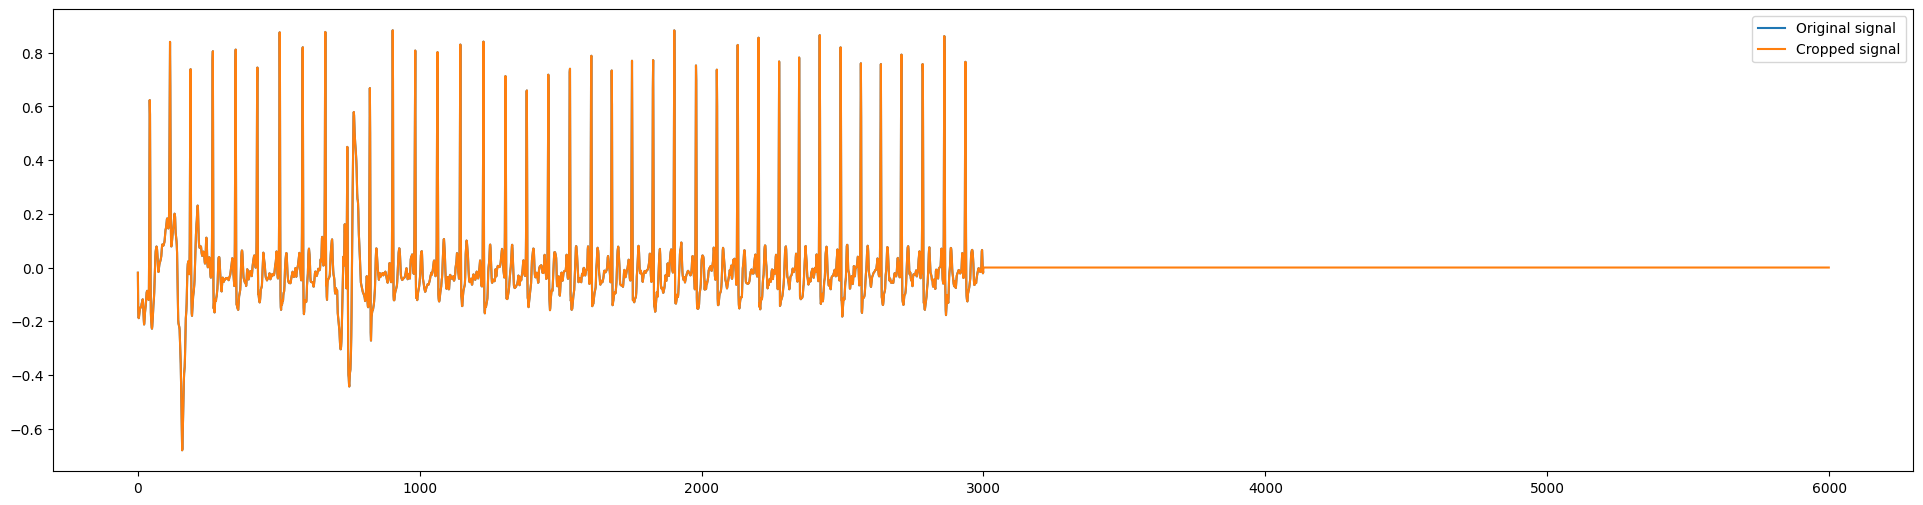

In [4]:
config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")

signal = np.loadtxt("dataset/preprocessed/A00001.csv")
signal = torch.tensor(signal, dtype=torch.float32)

random_scale = RandomTimeScale(factor=0.3, p=1)
random_noise = RandomNoise(
    signal_freq=dst_freq, noise_amplitude=0.2, noise_freq=dst_freq // 10, p=1
)
random_invert = RandomInvert(signal_freq=dst_freq, p=1)
random_mask = RandomMask(ratio_from=0.1, ratio_to=0.3, p=1)
random_crop = Crop(length=dst_freq * dst_time, mode="random", padding_if_needed=True)
min_max_norm = MinMaxNorm()

scaled_signal = random_scale(signal.numpy())
noise_signal = random_noise(signal.numpy())
inverted_signal = random_invert(signal)
masked_signal = random_mask(signal)
cropped_signal = random_crop(signal)
min_max_norm_signal = min_max_norm(signal)

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(scaled_signal).plot(figsize=(24, 6), label="Scaled signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(noise_signal).plot(figsize=(24, 6), label="Noise signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(inverted_signal).plot(figsize=(24, 6), label="Inverted signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(masked_signal).plot(figsize=(24, 6), label="Masked signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(cropped_signal).plot(figsize=(24, 6), label="Cropped signal")
plt.legend()
plt.show()

## Check Data Augmentation

In [5]:
import pandas as pd
from dataset_utils import Cinc2017DataModule

data_module = Cinc2017DataModule()
data_module.setup("fit")

<Axes: >

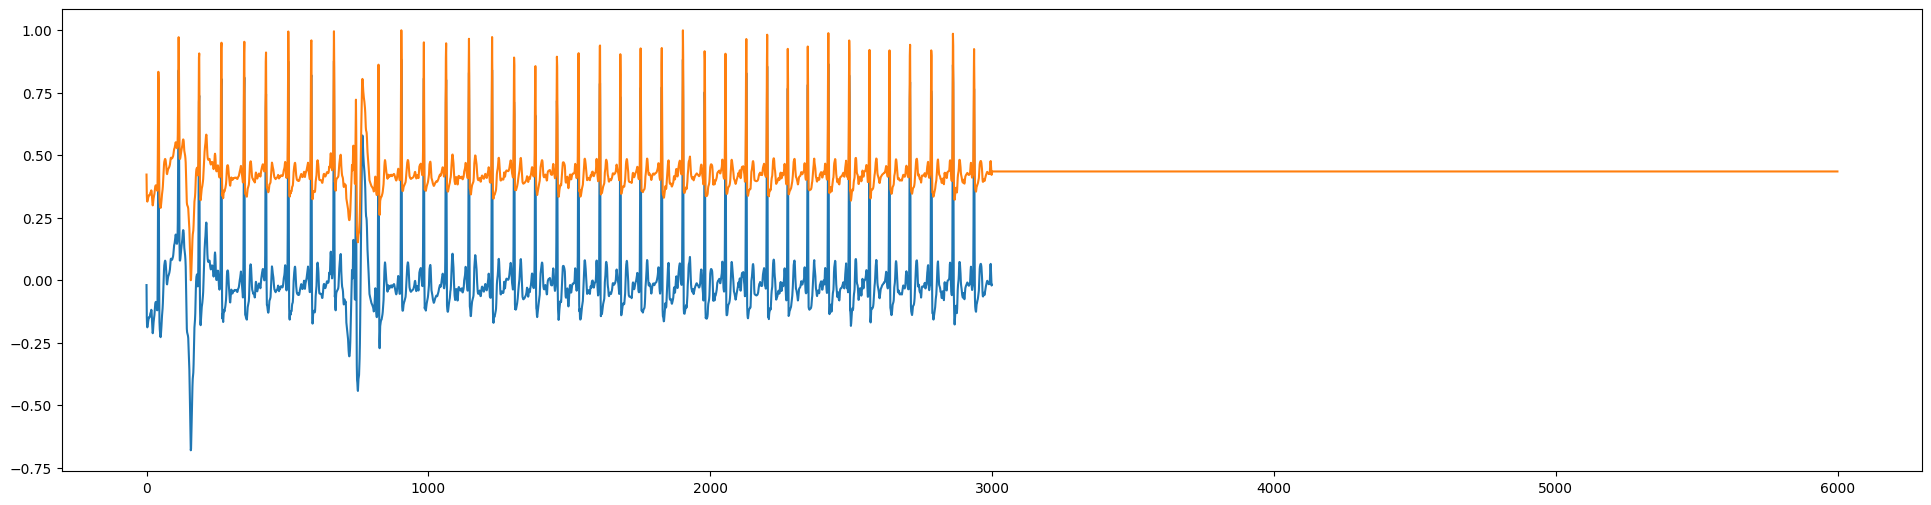

In [6]:
signal = data_module.train_set.signals[0]
signal_aug = data_module.train_set[0]['signal'][0]
pd.Series(signal).plot(figsize=(24, 6))
pd.Series(signal_aug).plot(figsize=(24, 6))

## NON-IID Dataset Partitioning

In [7]:
from dataset_utils import Cinc2017Dataset
from flwr_datasets.partitioner import DirichletPartitioner
from datasets import Dataset, ClassLabel
from flwr_datasets.visualization import plot_label_distributions

In [8]:
client_set = Cinc2017Dataset("train")

In [9]:
data = {"signal": client_set.signals, "label": client_set.labels}
dataset = Dataset.from_dict(data)
dataset = dataset.cast_column(
    "label", ClassLabel(names=client_set.classes)
)

Casting the dataset: 100%|██████████| 5773/5773 [00:00<00:00, 43781.75 examples/s]


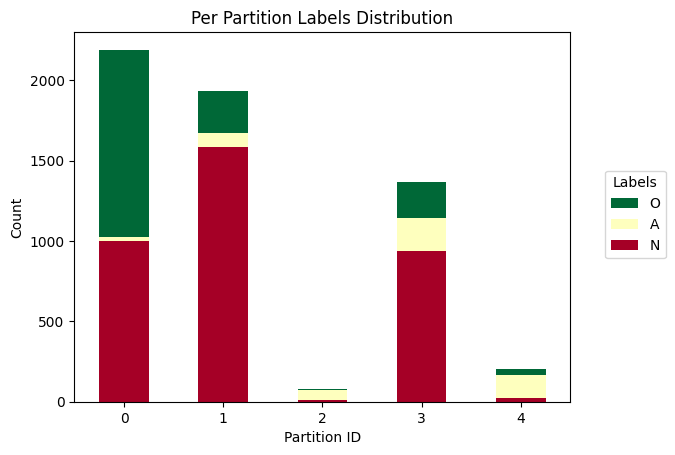

In [10]:
client_set_partitioner = DirichletPartitioner(
    num_partitions=5,
    partition_by="label",
    alpha=0.5,
    seed=42,
)

client_set_partitioner.dataset = dataset

fig, ax, df = plot_label_distributions(
    client_set_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)